### Importy

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from typing import Union, Dict, Optional, Tuple, Callable
import pandas as pd
import numpy as np

import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, PROJECT_ROOT)


from src.performance_metrics.performance_metrics import PerformanceMetrics
from src.performance_metrics.metrics_mesaurements import compare_metrics_df, plot_execution_times
from src.data.load_data import load_breath_cancer_data, load_students_data
from src.data.data_preparation import prepare_data, encode_categorical_columns
from src.models.abstract_classifier import AbstractClassifier
from src.confusion_matrix.compare_confusion_matrices import compare_confusion_matrices
from src.roc_curve.compare_roc_curves import compare_roc_curves

from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) # ignore warnings about undefinded metrics (no predictions were made)
warnings.filterwarnings('ignore', category=ConvergenceWarning) # ignore warnings about converging in sklearn

### Załadnowanie danych

In [134]:
breast_cancer_data = load_breath_cancer_data()

breast_cancer_data.head()

,ID,Diagnosis,radius1,texture1,perimiter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimiter3,area3,smoothness3,compactness3,concavity3,concave_points3,symetry3,fractial_dimention3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [135]:
students_data = load_students_data()
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [136]:
students_categorical_columns = students_data.select_dtypes(include=['object']).columns.tolist()
students_categorical_columns

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [137]:
students_data = encode_categorical_columns(students_data, students_categorical_columns)
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


# Porównanie otrzymywanych wyników między naszą implementacją a implementacją sklear

### Pomocnicze funkcje

In [139]:
def get_model_results(model, x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame, y_test: pd.Series) -> Tuple[np.ndarray, pd.Series]:
    classifier_model = AbstractClassifier(model, x_train, x_test, y_train)
    classifier_model.fit()
    predictions = classifier_model.predict()
    return predictions, y_test


def get_model_results_for_roc(model, x_train: pd.DataFrame, y_train: pd.Series,
                              x_test: pd.DataFrame, y_test: pd.Series,
                              positive_class: str) -> Tuple[np.ndarray, np.ndarray]:
    classifier_model = AbstractClassifier(model, x_train, x_test, y_train)
    classifier_model.fit()

    proba = classifier_model.predict_proba()
    class_index = list(classifier_model.model.classes_).index(positive_class)
    y_scores = proba[:, class_index]

    y_true_binary = (y_test == positive_class).astype(int).values

    return y_scores, y_true_binary

### Załadowanie danych

In [140]:
x_breast_cancer, x_test_breast_cancer, y_train_breast_cancer, y_test_breast_cancer = prepare_data(
    breast_cancer_data, target_column="Diagnosis")

In [141]:
x_students, x_test_students, y_train_students, y_test_students = prepare_data(
    students_data, target_column="G1", test_size=0.3, stratify=False)

### Modele

In [142]:
logistic_regression = LogisticRegression(max_iter=2500)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
linear_svc = SVC(kernel='linear', probability=True, max_iter=2500)
mlp_classifier = MLPClassifier(max_iter=2500)

## 1. Logistic Regression

#### Breast Cancer

In [143]:
predictions, actual = get_model_results(logistic_regression, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

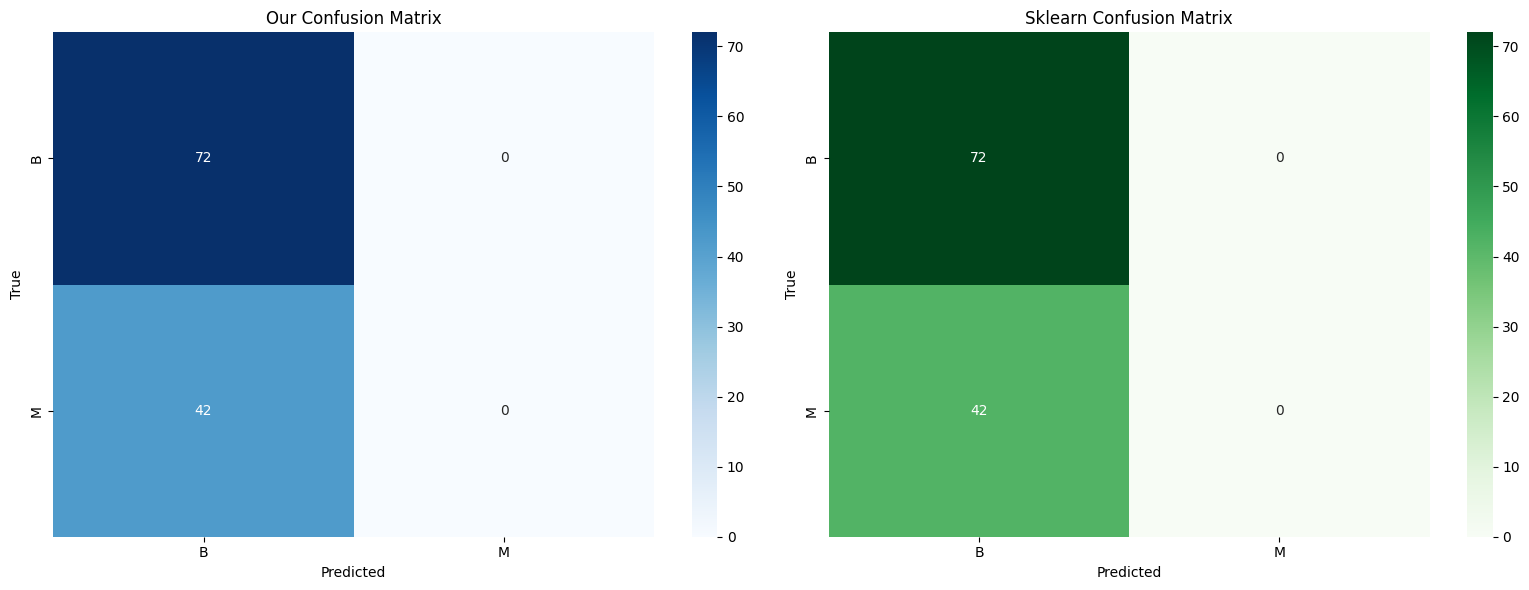

In [144]:
compare_confusion_matrices(actual, predictions)

In [145]:
predictions, actual = get_model_results_for_roc(logistic_regression, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer, 'M')

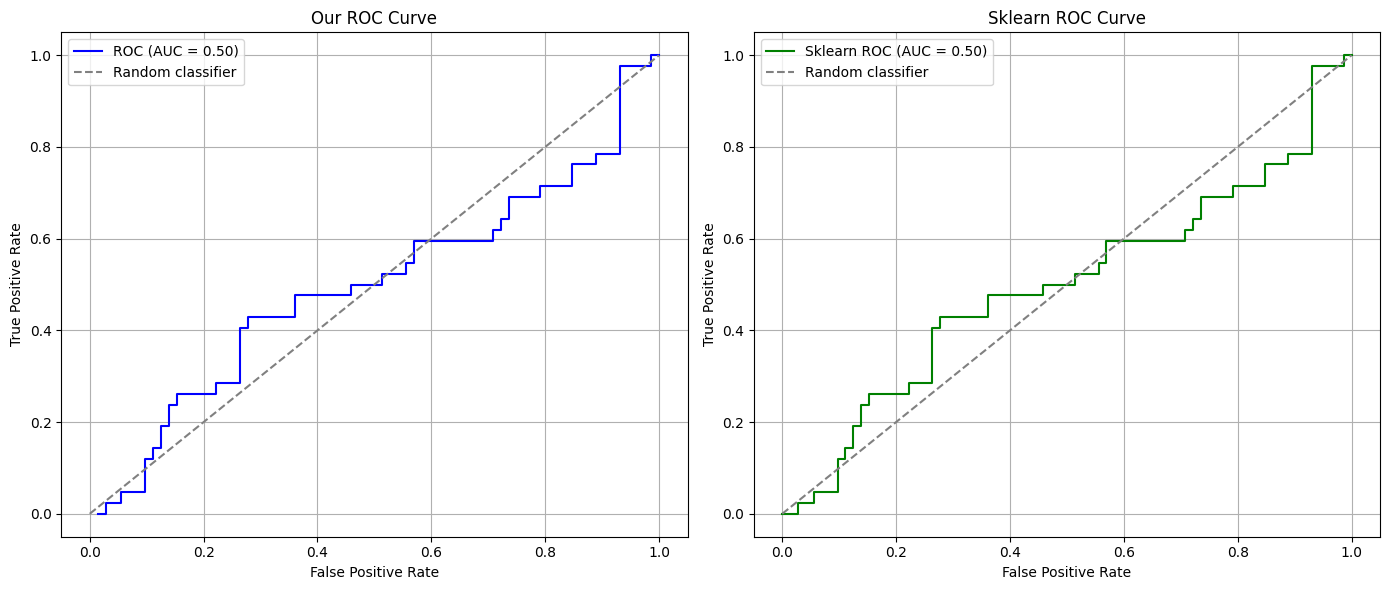

In [147]:
compare_roc_curves(actual, predictions) # dla klasy M

#### Students

In [148]:
predictions, actual = get_model_results(logistic_regression, x_students, y_train_students, x_test_students, y_test_students)

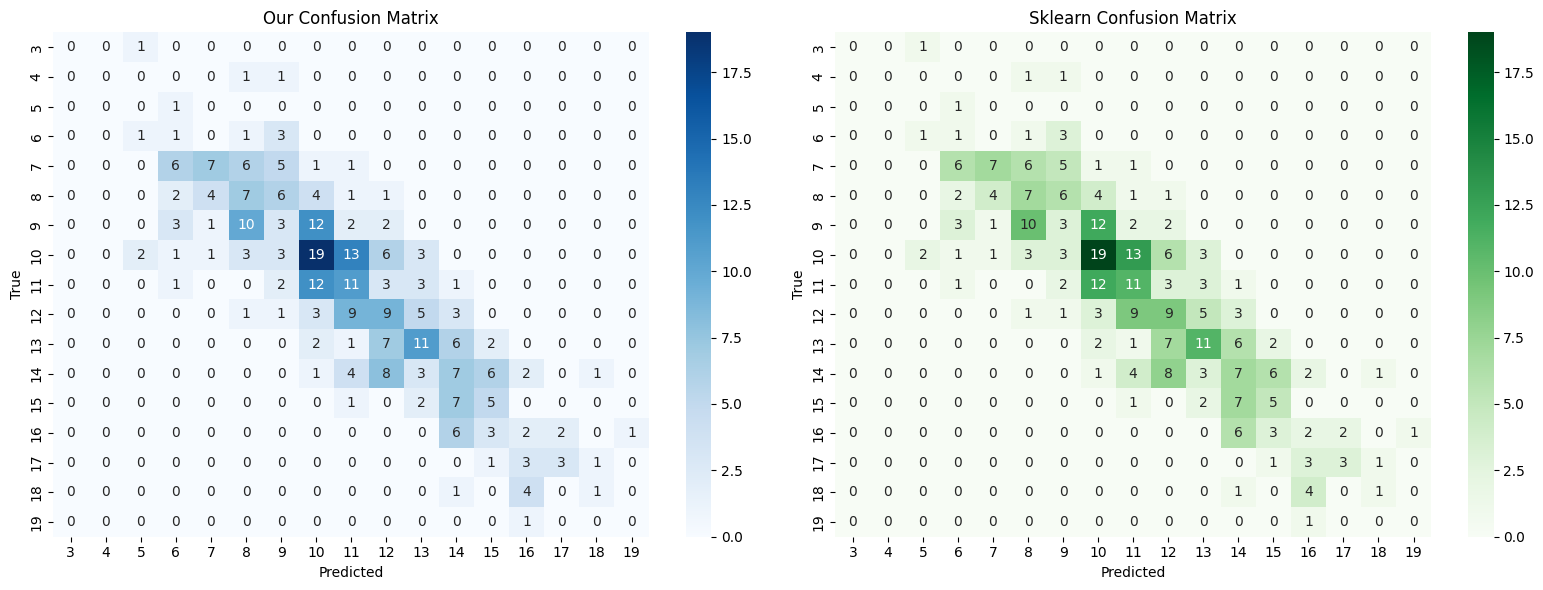

In [149]:
compare_confusion_matrices(actual, predictions)

In [150]:
predictions, actual = get_model_results_for_roc(logistic_regression, x_students, y_train_students, x_test_students, y_test_students, 18)

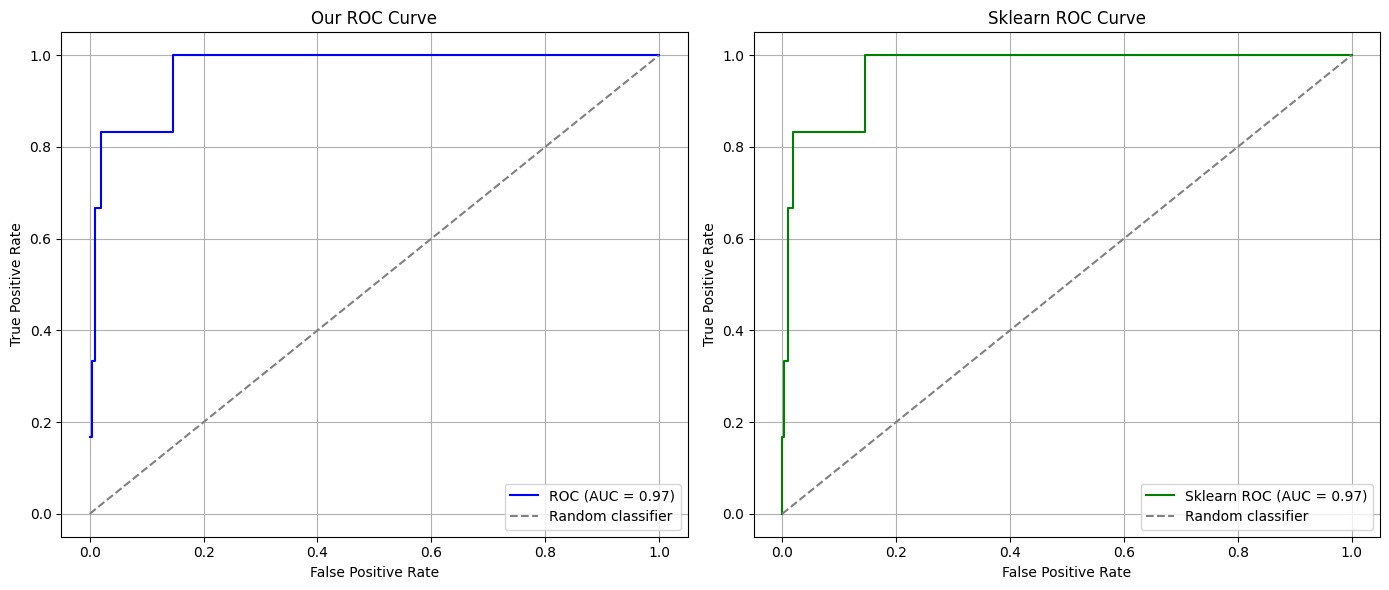

In [151]:
compare_roc_curves(actual, predictions) # dla klasy 18

## 2. Decision Tree

#### Breast Cancer

In [152]:
predictions, actual = get_model_results(decision_tree, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

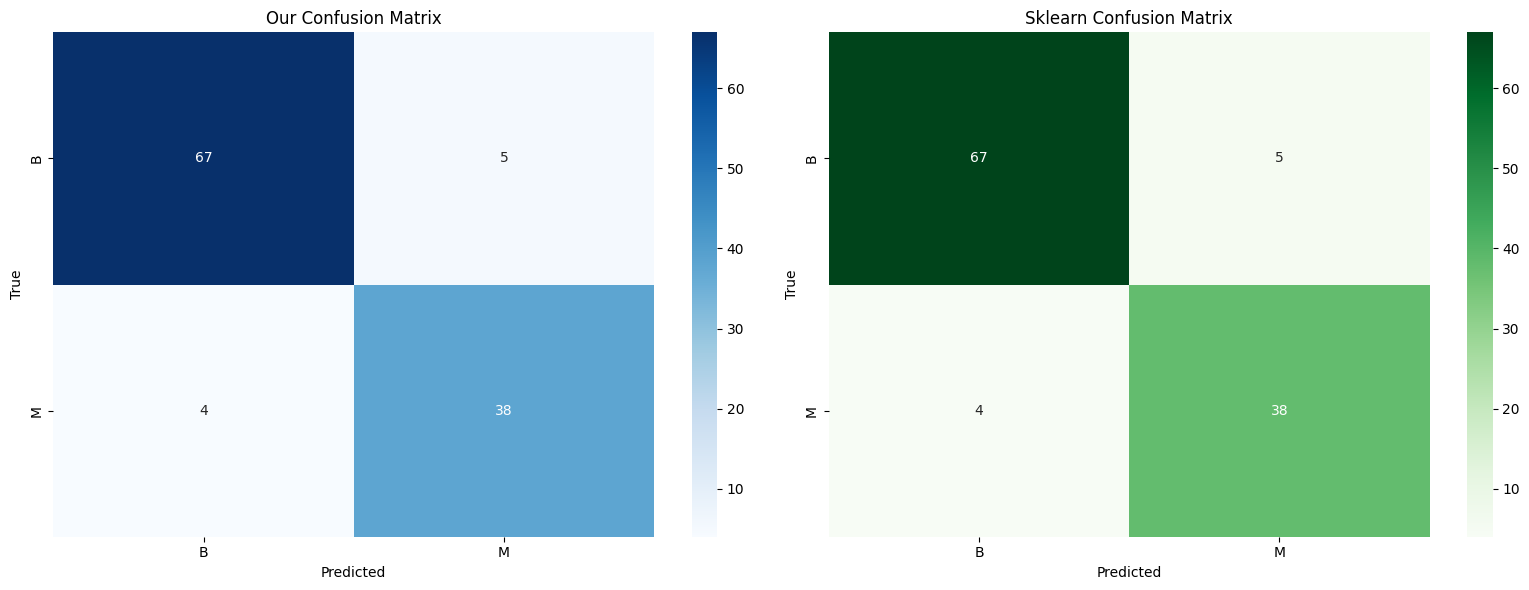

In [153]:
compare_confusion_matrices(actual, predictions)

In [154]:
predictions, actual = get_model_results_for_roc(decision_tree, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer, 'M')

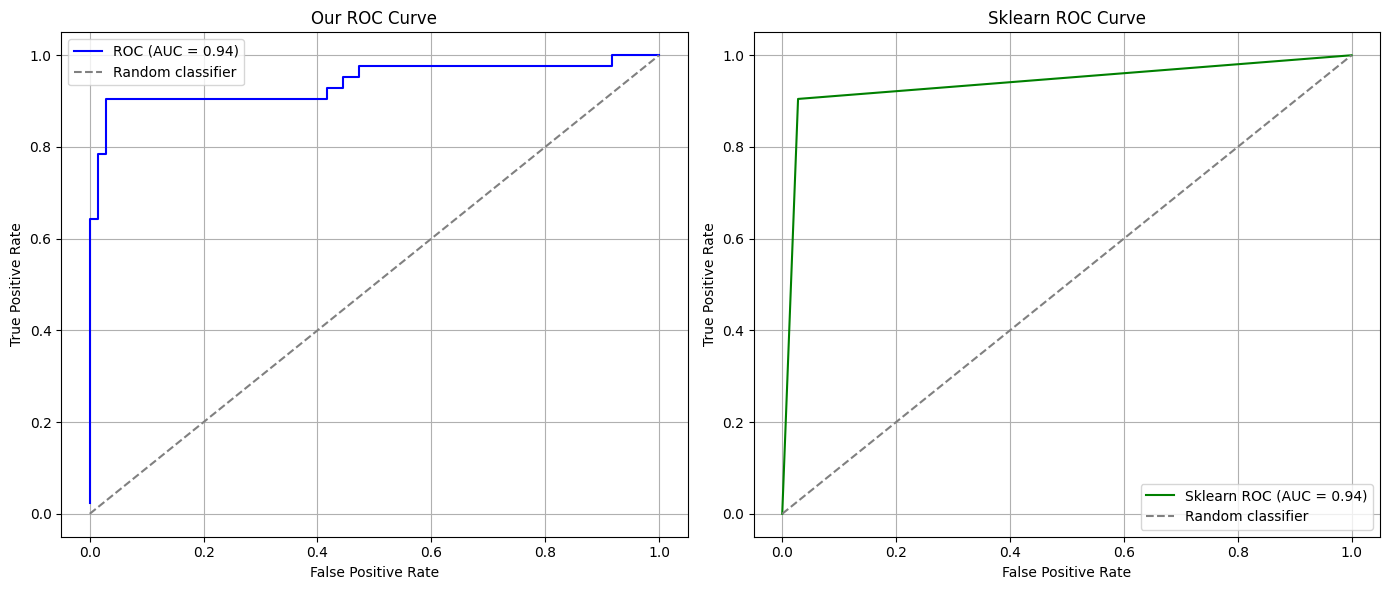

In [155]:
compare_roc_curves(actual, predictions)

#### Students

In [156]:
predictions, actual = get_model_results(decision_tree, x_students, y_train_students, x_test_students, y_test_students)

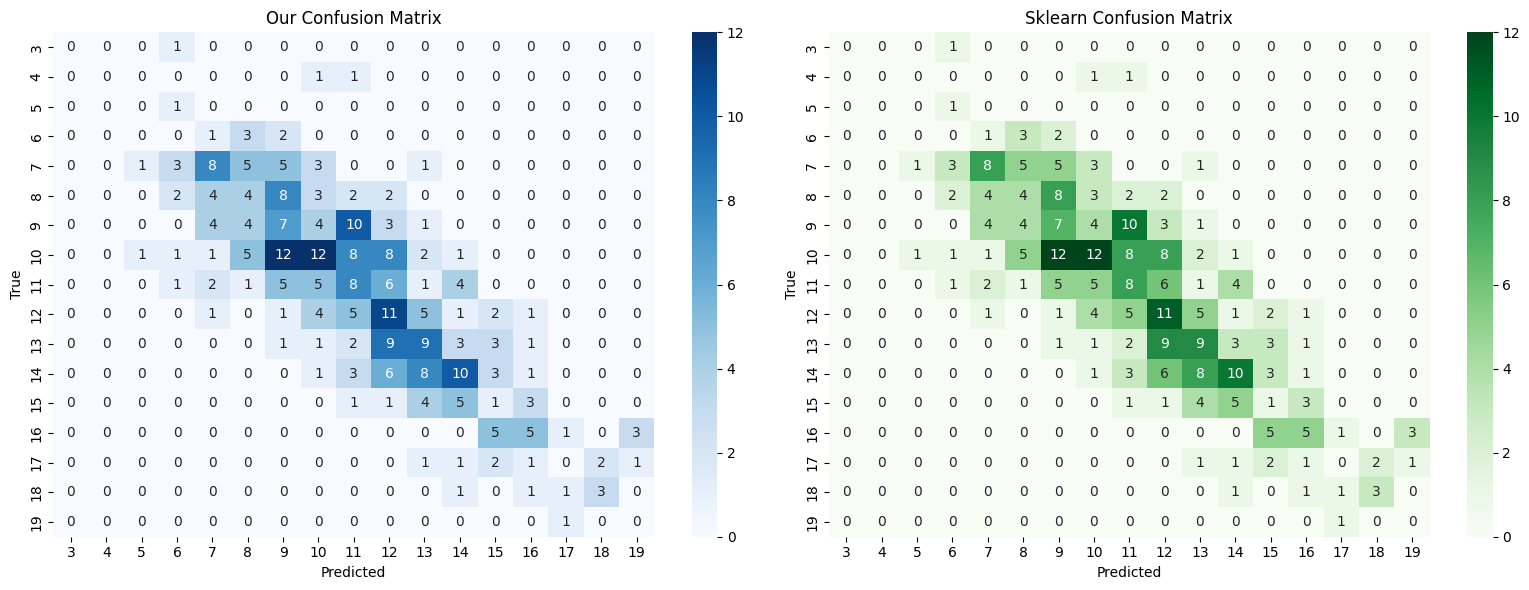

In [157]:
compare_confusion_matrices(actual, predictions)

In [158]:
predictions, actual = get_model_results_for_roc(decision_tree, x_students, y_train_students, x_test_students, y_test_students, 18)

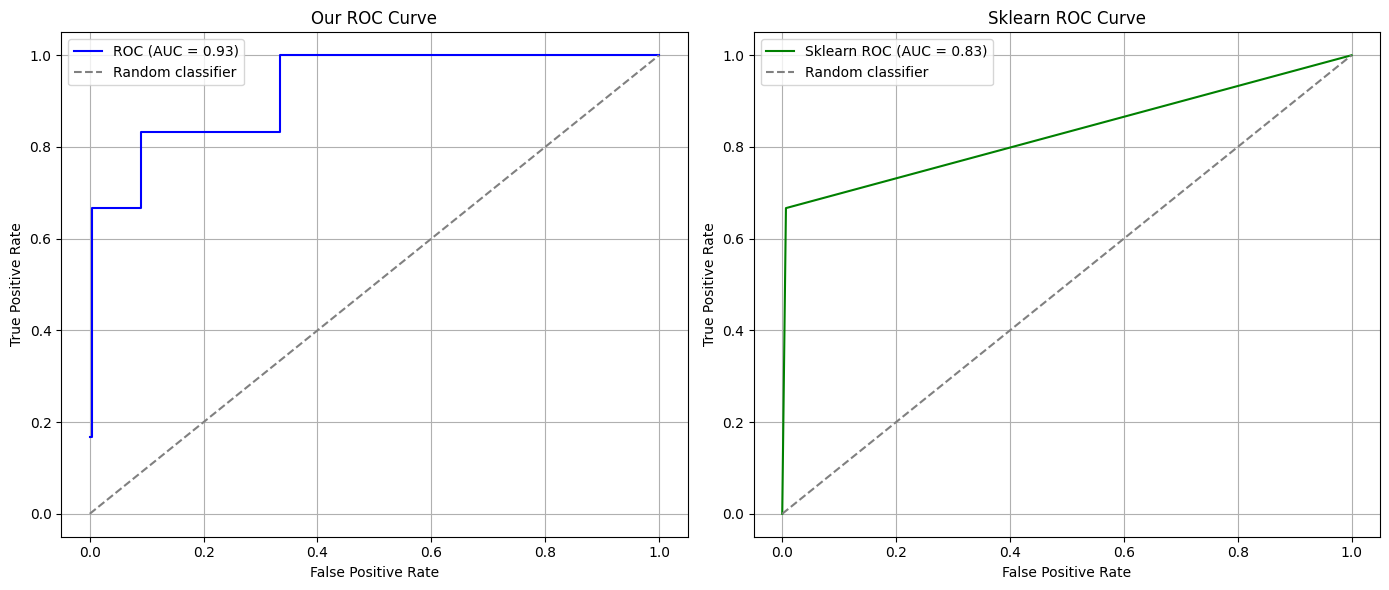

In [159]:
compare_roc_curves(actual, predictions)

## 3. Random Forest

#### Breast Cancer

In [160]:
predictions, actual = get_model_results(random_forest, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

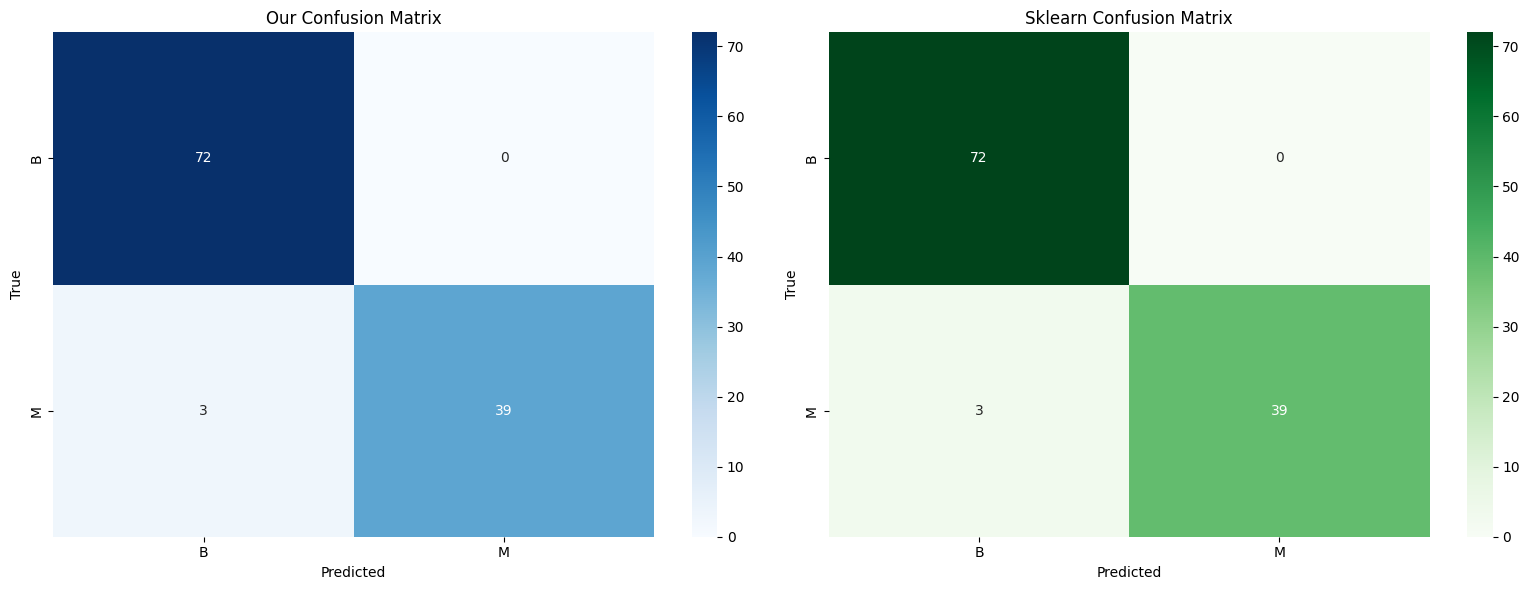

In [161]:
compare_confusion_matrices(actual, predictions)

In [162]:
predictions, actual = get_model_results_for_roc(random_forest, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer, 'M')

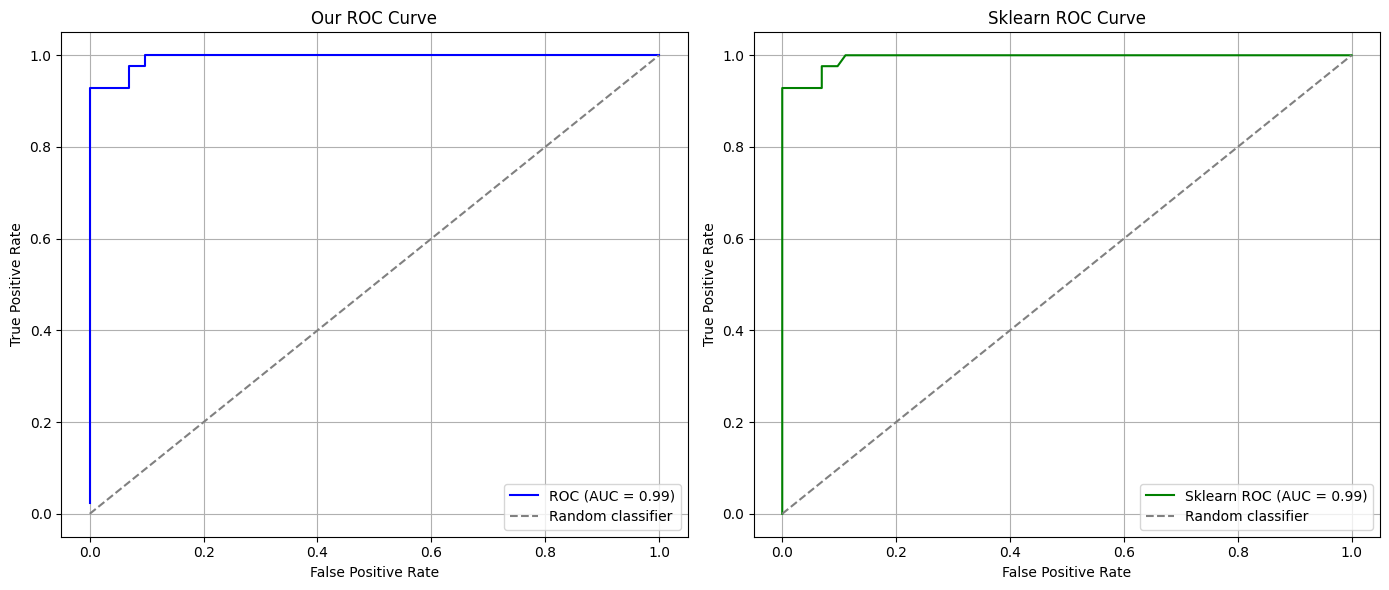

In [163]:
compare_roc_curves(actual, predictions)

#### Students

In [164]:
predictions, actual = get_model_results(random_forest, x_students, y_train_students, x_test_students, y_test_students)

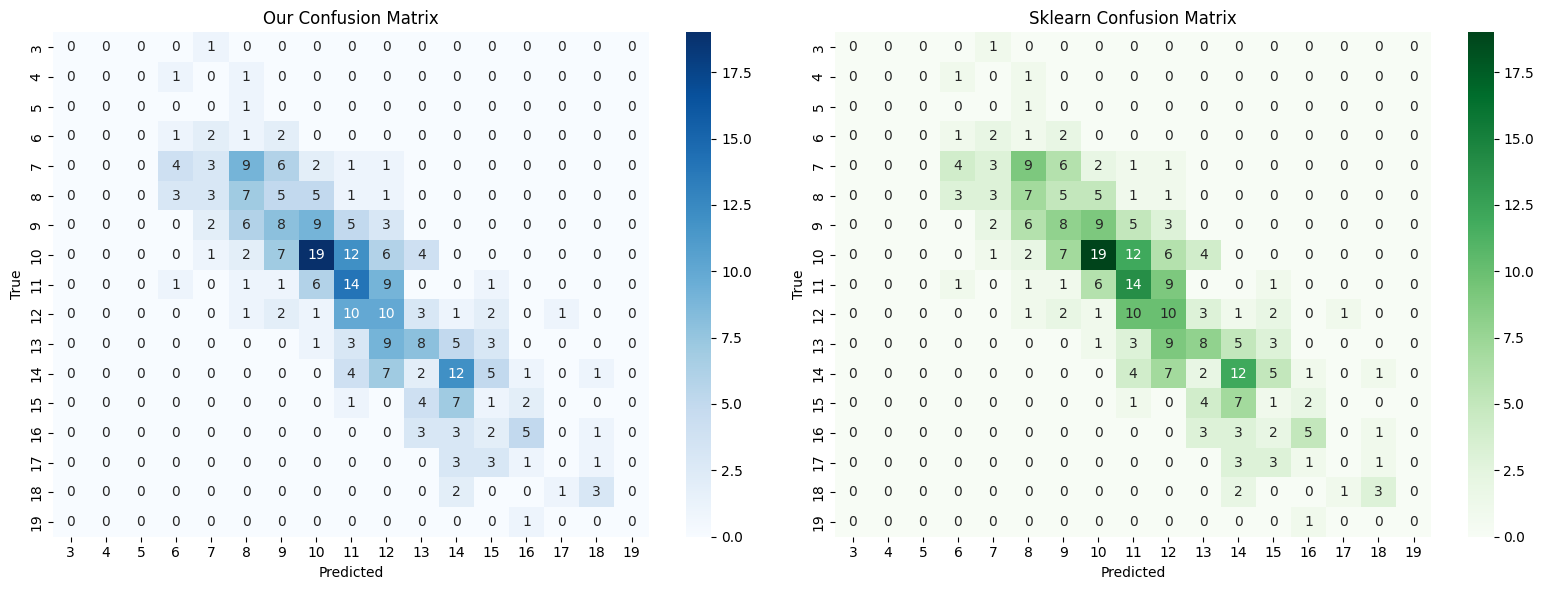

In [165]:
compare_confusion_matrices(actual, predictions)

In [166]:
predictions, actual = get_model_results_for_roc(random_forest, x_students, y_train_students, x_test_students, y_test_students, 18)

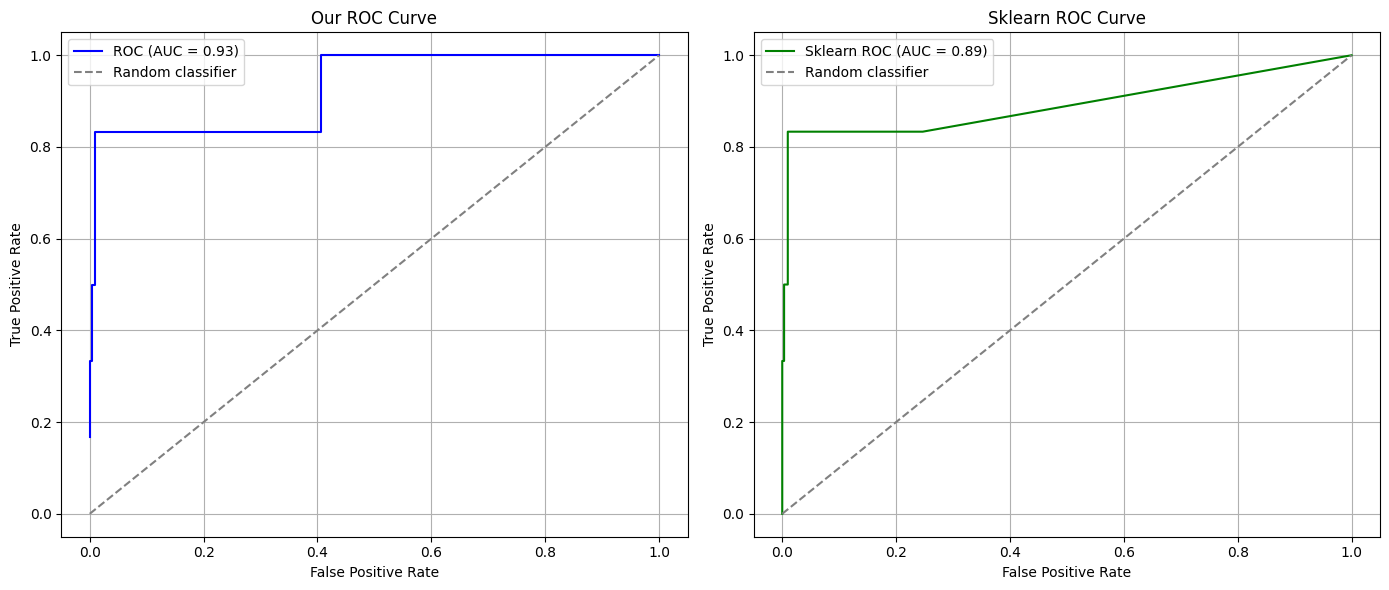

In [167]:
compare_roc_curves(actual, predictions)

## 4. SVM

#### Breast Cancer

In [168]:
predictions, actual = get_model_results(linear_svc, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

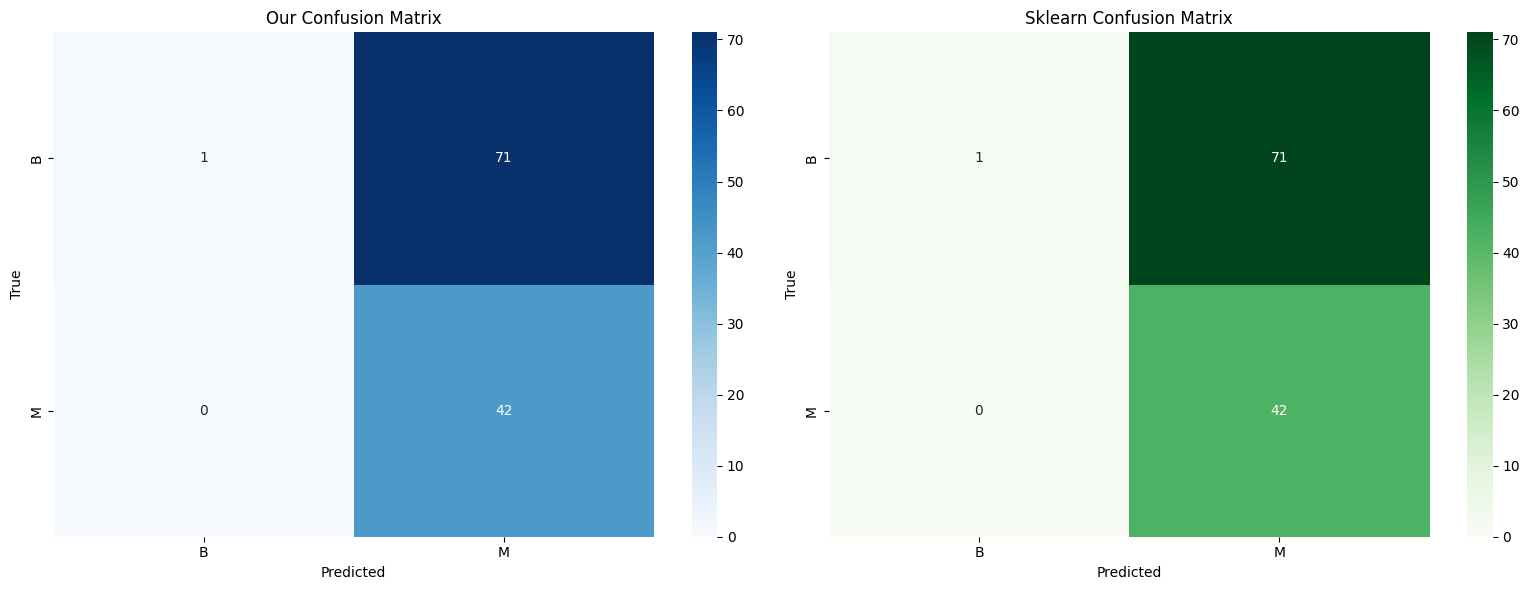

In [169]:
compare_confusion_matrices(actual, predictions)

In [170]:
predictions, actual = get_model_results_for_roc(linear_svc, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer, 'M')

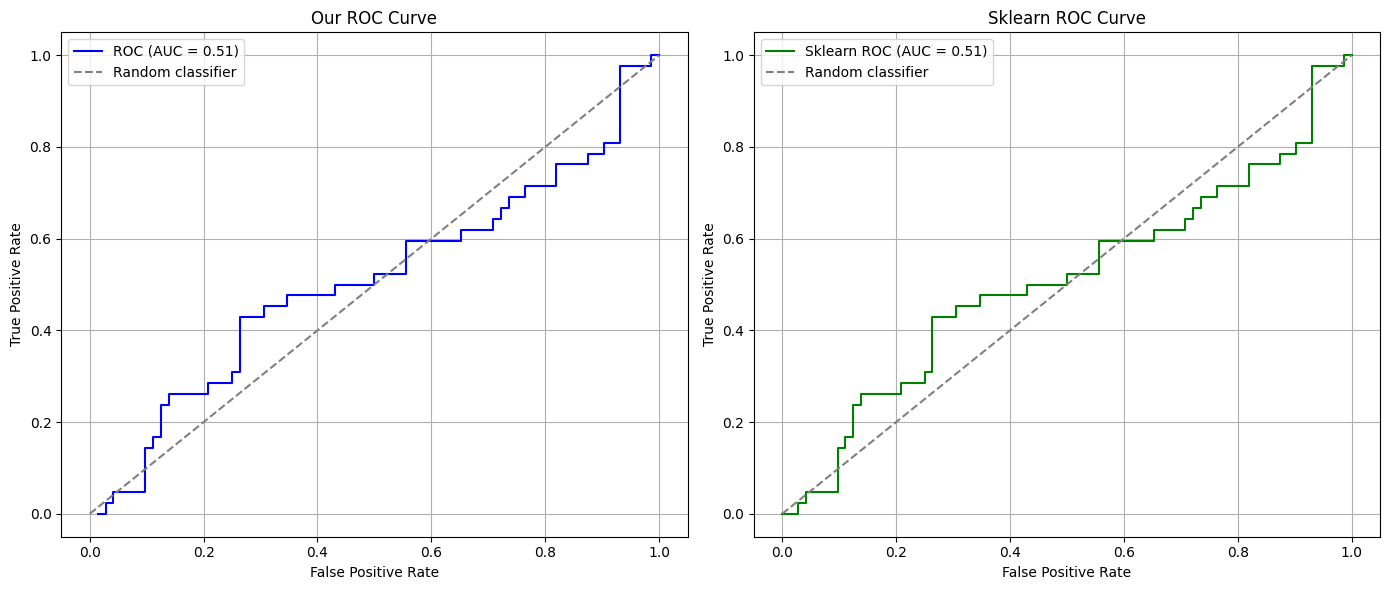

In [171]:
compare_roc_curves(actual, predictions)

#### Students

In [172]:
predictions, actual = get_model_results(linear_svc, x_students, y_train_students, x_test_students, y_test_students)

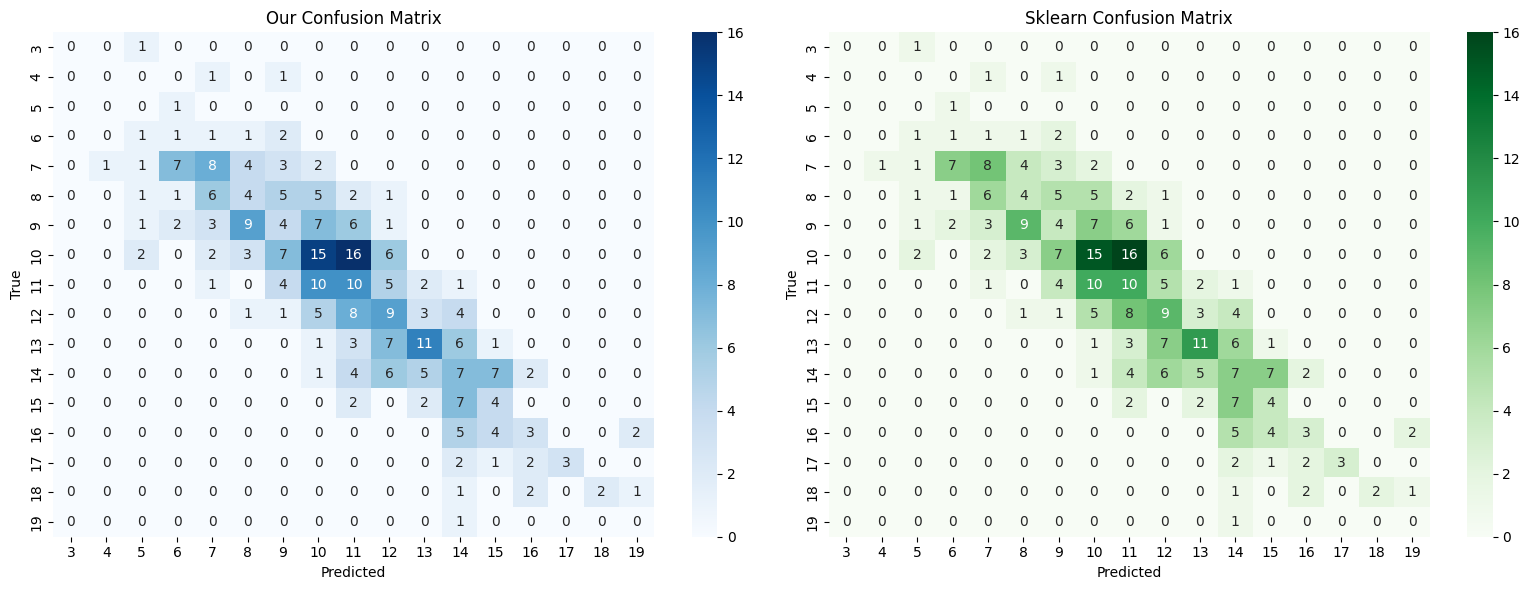

In [173]:
compare_confusion_matrices(actual, predictions)

In [174]:
predictions, actual = get_model_results_for_roc(linear_svc, x_students, y_train_students, x_test_students, y_test_students, 18)

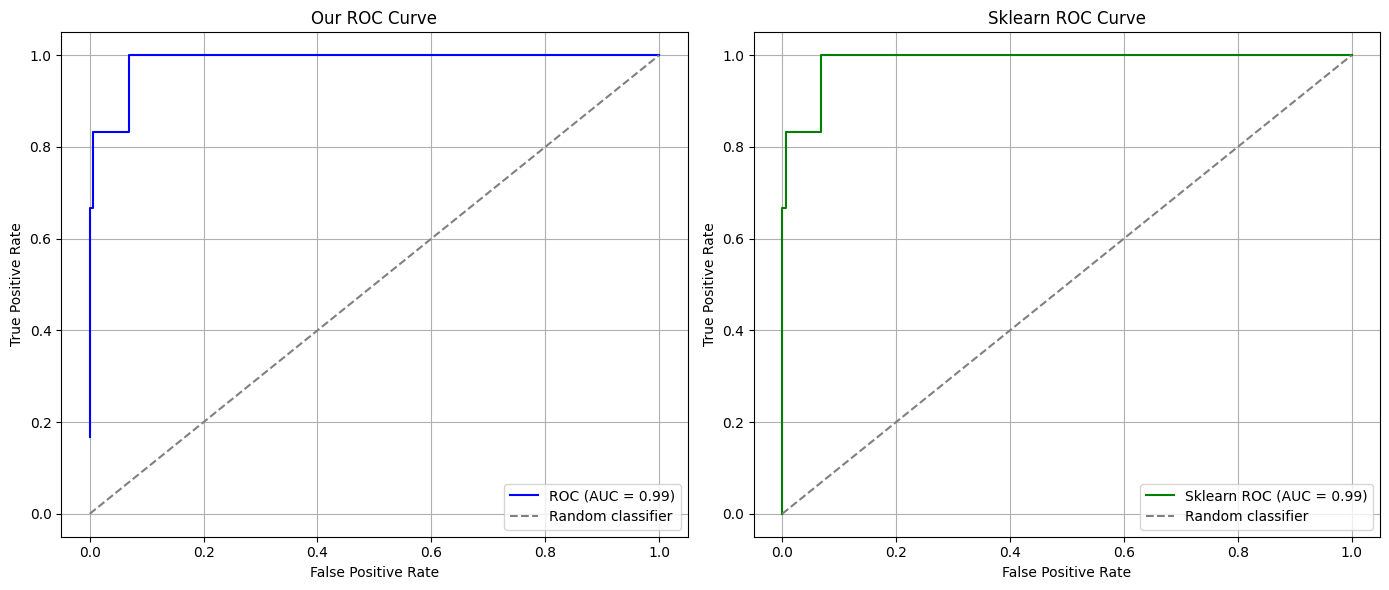

In [175]:
compare_roc_curves(actual, predictions)

## 5. MLPClassifier

#### Breast Cancer

In [176]:
predictions, actual = get_model_results(mlp_classifier, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

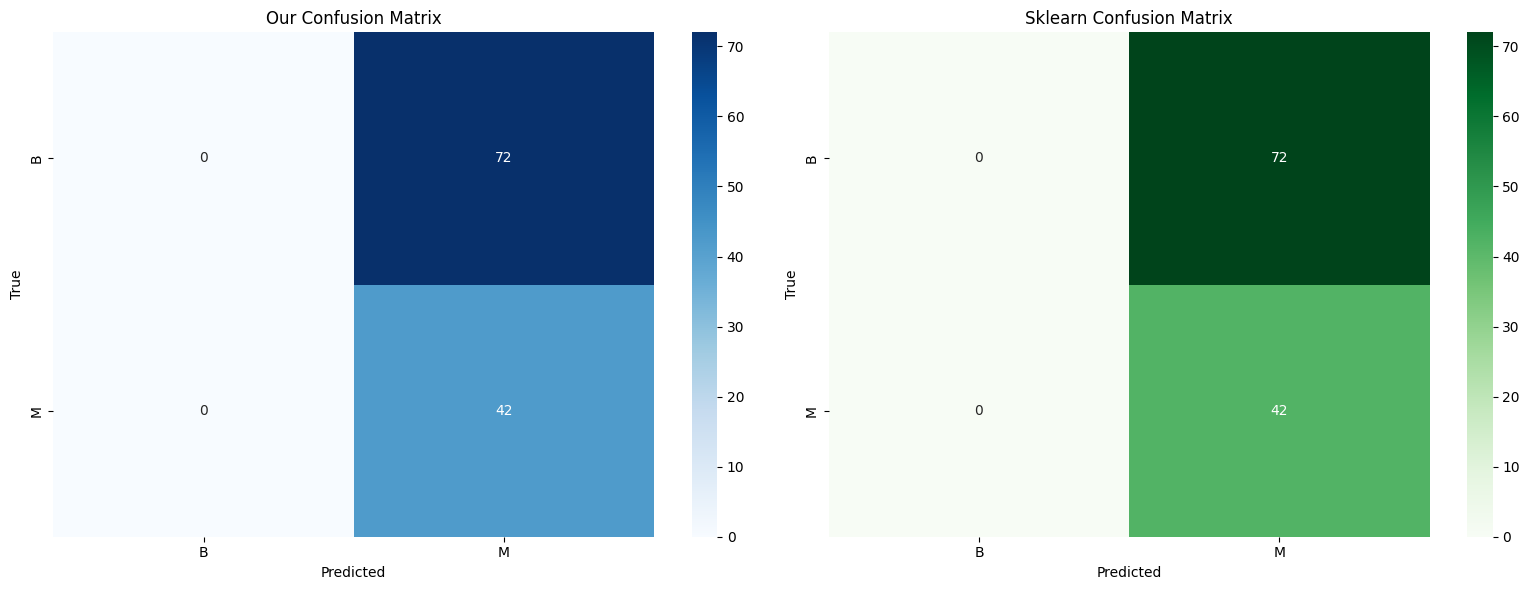

In [177]:
compare_confusion_matrices(actual, predictions)

In [178]:
predictions, actual = get_model_results_for_roc(mlp_classifier, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer, 'M')

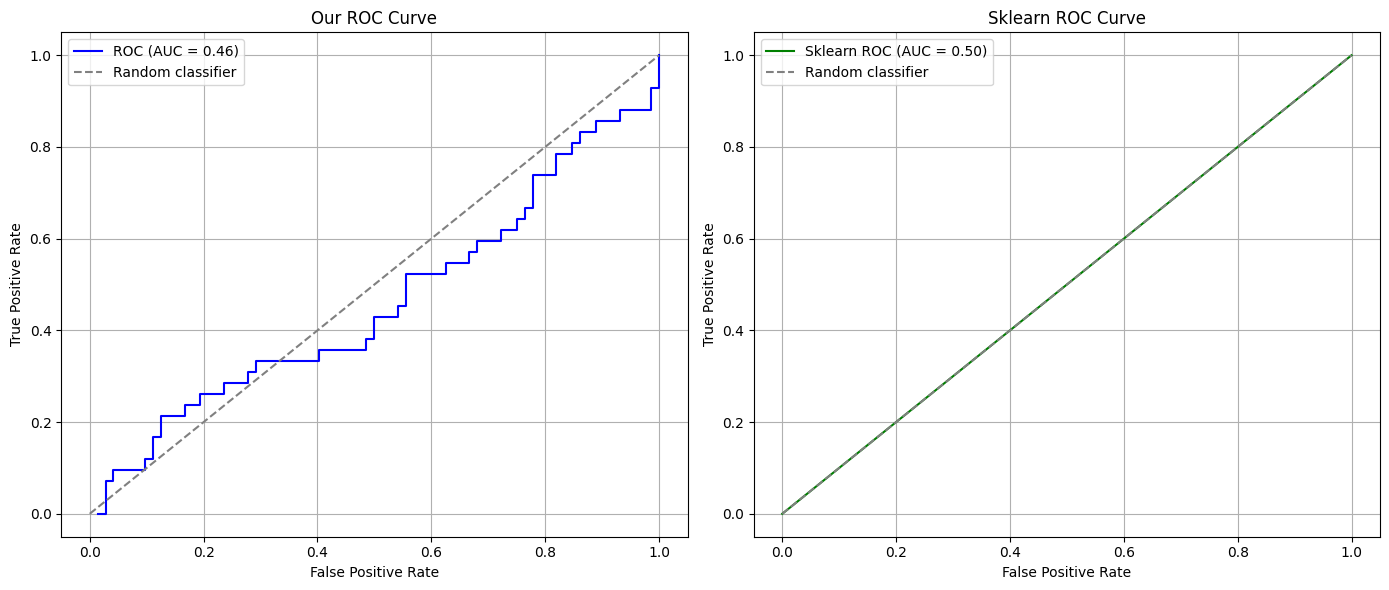

In [179]:
compare_roc_curves(actual, predictions)

#### Students

In [180]:
predictions, actual = get_model_results(mlp_classifier, x_students, y_train_students, x_test_students, y_test_students)

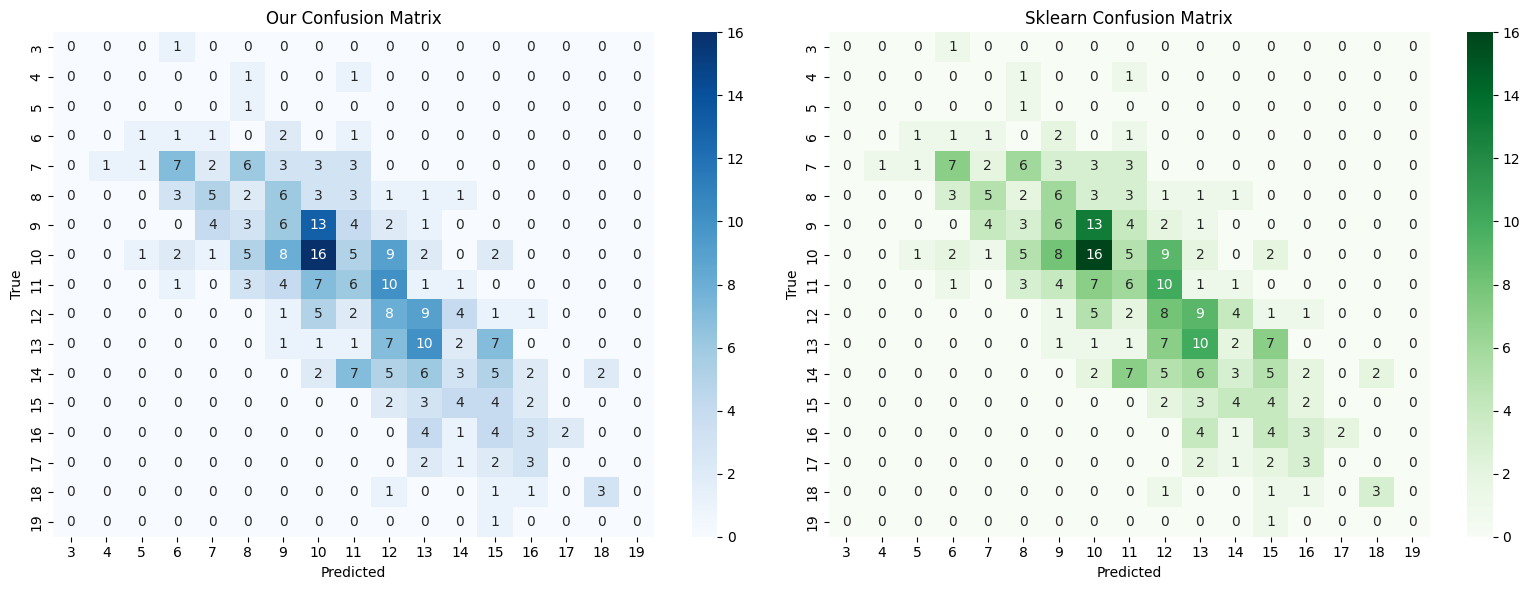

In [181]:
compare_confusion_matrices(actual, predictions)

In [182]:
predictions, actual = get_model_results_for_roc(mlp_classifier, x_students, y_train_students, x_test_students, y_test_students, 18)

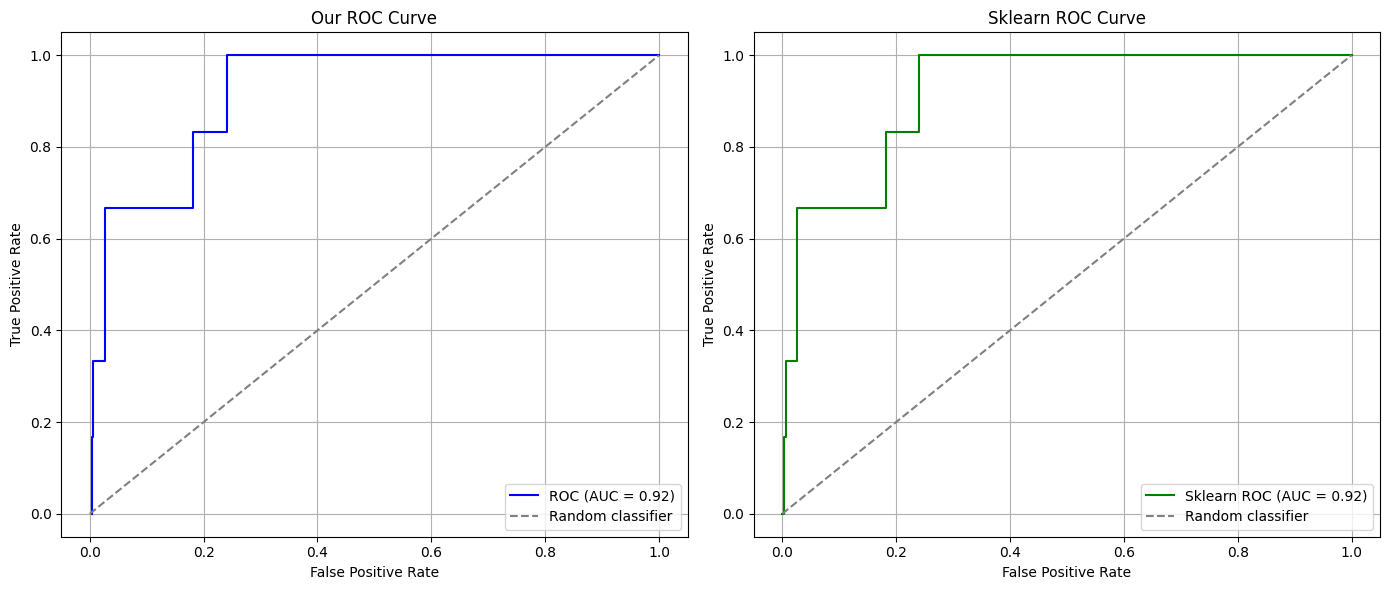

In [183]:
compare_roc_curves(actual, predictions)

# Wnioski

- Zarówno nasza implementacja, jak i ta z biblioteki scikit-learn zwracają identyczne wyniki na podstawie tych samych predykcji i wartości rzeczywistych.